# Homework 11

**Harvard University**<br>
**Fall 2018**<br>
**Instructors: Rahul Dave**<br>
**Due Date:** Saturday, December 1st, 2018 at 11:59pm

**Instructions:**

- Upload your final answers in the form of a Jupyter notebook containing all work to Canvas.

- Structure your notebook and your work to maximize readability.

### Collaborators

** Place the name of everyone who's submitting this assignment here**

<div class="answer-separator">
------------------------
</div>

In [1]:
import numpy as np
import scipy.stats
import scipy.special

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
from matplotlib import cm

import pandas as pd
import seaborn as sns

import pymc3 as pm
from theano import shared
import arviz as az

%matplotlib inline

## Question 1: Crazy Rich Bayesians Don't Need No Educations?

**coding required**

In this problem, you will explore how to recast data, tasks and research questions from a variety of different contexts so that an existing model can be applied for analysis.

Example 10.1.3 in ["Statistical Rethinking"](https://piazza.com/redirect/s3?bucket=uploads&prefix=attach%2Fjlo4e4ari3r4wd%2Fj9vjyzv62x149%2Fjopa0chtr7ns%2FStatistical_Rethinking_excerpt.pdf), the excerpt of which is included with this assignment, illustrates a study of the effect of an applicant's gender on graduate school admissions to six U.C. Berkeley departments through a comparison of four models. 

In this problem, you are given data from the [1994 U.S. Census](https://piazza.com/redirect/s3?bucket=uploads&prefix=attach%2Fjlo4e4ari3r4wd%2Fj9vjyzv62x149%2Fjop9zvsjoscq%2Fcensus_data.csv). The data has been processed so that only a subset of the features are present (for full dataset as well as the description see the [UCI Machine Learning Repository](http://archive.ics.uci.edu/ml/datasets/Census+Income)). You will be investigate the effect of gender on a person's yearly income in the dataset. In particular, we want to know how a person's gender effect the likelihood of their yearly salary being above or below \$50k. 

1.1. Read the dataset into a dataframe and aggregate the dataset by organizing the  dataframe into seven different categories. 

The categories we wish to consider are: 
* 4 year college degree
* Some-college or two year academic college degree
* High school
* Professional, vocational school
* Masters 
* Doctorate
* Some or no high school

Note that you might have to combine some of the existing education categories in your dataframe. For each category, we suggest that you only keep track of a count of the number of males and females who make above (and resp. below) the crazy rich income of $50k (see the dataset in Example 10.1.3). 

1.2. Following Example 10.1.3, build two models for the classification of an individual's yearly income (1 being above \$50k and 0 being below), one of these models should include the effect of gender while the other should not. 

1.3. Replicate the analysis in 10.1.3 using your models; specifically, compute wAIC scores and make a plot like Figure 10.5 (posterior check) to see how well your models fits the data. 

1.4. Following Example 10.1.3, build two models for the classification of an individual's yearly income taking into account education. One of the models should take into account education only the other should take into account gender and education on income.

1.5. Replicate the analysis in 10.1.3 using your models; specifically, compute wAIC scores and make a plot like Figure 10.6 (posterior check) to see how well your model fits the data.

1.6. Using your analysis from 1.3, discuss the effect gender has on income.

1.7. Using your analysis from 1.5, discuss the effect of gender on income taking into account an individual's education.

(**Hint: If you haven't seen WAIC, it's because we'll be covering it on Monday November 26, 2018.  In the meantime checkout info about WAIC in this resource on [PyMC3 model selection](https://docs.pymc.io/notebooks/model_comparison.html).**)

> 1.1. Read the dataset into a dataframe and aggregate the dataset by organizing the  dataframe into seven different categories. 

> The categories we wish to consider are: 
* 4 year college degree
* Some-college or two year academic college degree
* High school
* Professional, vocational school
* Masters 
* Doctorate
* Some or no high school

> Note that you might have to combine some of the existing education categories in your dataframe. For each category, we suggest that you only keep track of a count of the number of males and females who make above (and resp. below) the crazy rich income of $50k (see the dataset in Example 10.1.3). 

In [2]:
df = pd.read_csv("census_data.csv", index_col=0)
df.edu.value_counts()

HS-grad         10501
Some-college     7291
Bachelors        5355
Masters          1723
Assoc-voc        1382
11th             1175
Assoc-acdm       1067
10th              933
7th-8th           646
Prof-school       576
9th               514
12th              433
Doctorate         413
5th-6th           333
1st-4th           168
Preschool          51
Name: edu, dtype: int64

In [3]:
df.loc[df.edu.isin(['Preschool', '1st-4th', '5th-6th', '7th-8th', '9th', '10th', '11th', '12th']), "edu"] = "Some or no high school"
df.loc[df.edu.isin(['Assoc-voc', 'Assoc-acdm','Prof-school']), "edu"] =  "Professional, vocational school"
df.loc[df.edu.isin(['Some-college']), "edu"] = "Some-college or two year academic college degree"
df.loc[df.edu == "Bachelor", "edu"] = "4 year college degree"
print(df.edu.value_counts())

df['target'] = 0
df.loc[df.earning != "<=50K", 'target'] = 1

df["sex_cat"] = 0
df.loc[df.sex == "Male", "sex_cat"] = 1
df.head()

HS-grad                                             10501
Some-college or two year academic college degree     7291
Bachelors                                            5355
Some or no high school                               4253
Professional, vocational school                      3025
Masters                                              1723
Doctorate                                             413
Name: edu, dtype: int64


,age,sector,edu,marital,race,sex,earning,target,sex_cat
0,39,State-gov,Bachelors,Never-married,White,Male,<=50K,0,1
1,50,Self-emp-not-inc,Bachelors,Married-civ-spouse,White,Male,<=50K,0,1
2,38,Private,HS-grad,Divorced,White,Male,<=50K,0,1
3,53,Private,Some or no high school,Married-civ-spouse,Black,Male,<=50K,0,1
4,28,Private,Bachelors,Married-civ-spouse,Black,Female,<=50K,0,0


> 1.2. Following Example 10.1.3, build two models for the classification of an individual's yearly income (1 being above \$50k and 0 being below), one of these models should include the effect of gender while the other should not. 


In [387]:
with pm.Model() as no_gender:
    alpha = pm.Normal('alpha', mu=0, sd=1)
    obs = pm.Bernoulli('observed', logit_p=alpha, observed=df.target)
    trace1 = pm.sample(2000)
    
no_gender.name = 'No Gender'

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [alpha]
Sampling 2 chains: 100%|██████████| 5000/5000 [00:22<00:00, 224.56draws/s]


In [5]:
with pm.Model() as gender:
    alpha = pm.Normal('alpha', mu=0, sd=1)
    beta = pm.Normal('beta', mu=0, sd=1)
    log_p = alpha + beta * df.sex_cat
    obs = pm.Bernoulli('observed', logit_p=log_p, observed=df.target)
    trace2 = pm.sample(2000)
    
gender.name = 'Gender'

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta, alpha]
Sampling 2 chains: 100%|██████████| 5000/5000 [00:43<00:00, 114.56draws/s]
The acceptance probability does not match the target. It is 0.8874911983806687, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


We go over the diagnostics for the second trace here. We checked the first one as well, but don't show the results. Let's start with the traceplot:

/anaconda/lib/python3.6/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/anaconda/lib/python3.6/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x120307160>,
      dtype=object)

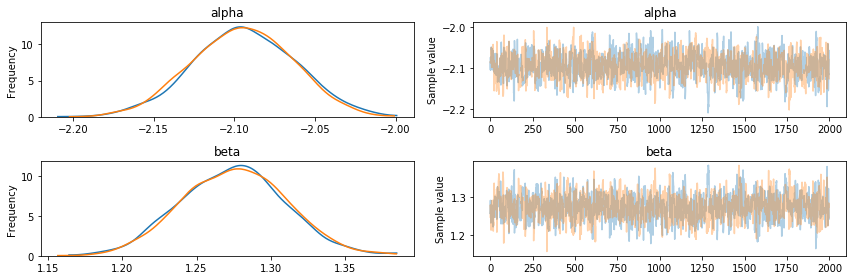

In [6]:
pm.traceplot(trace2)

It looks kind of ok. The sampler does not get stuck for longer time in any region. Since we only sample 2000 samples from the posterior distribution, we're not too worried about the two chains not lying directly on top of each other.

The autocorrelation plot looks good. It decay to no autocorrelation after only a few steps.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x12254e278>,
      dtype=object)

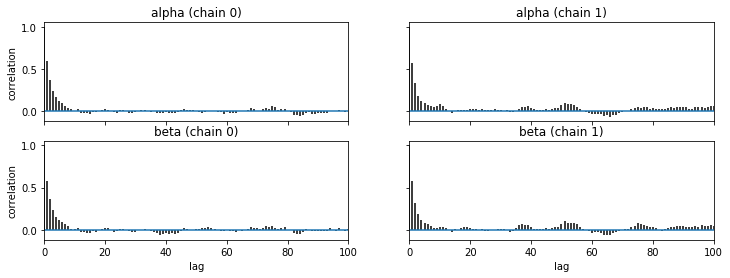

In [7]:
pm.autocorrplot(trace2)

Also, the Gelman-Rubin statistics looks good. 

In [8]:
pm.summary(trace2)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
alpha,-2.094977,0.031459,0.001000,-2.156627,-2.033692,900.269742,1.000425
beta,1.274748,0.034707,0.001066,1.206469,1.341017,950.358972,1.000297


In summary, there's no reason to suspect that something is wrong with the chains.

> 1.3. Replicate the analysis in 10.1.3 using your models; specifically, compute wAIC scores and make a plot like Figure 10.5 (posterior check) to see how well your models fits the data. 

So, let's start analyzing the results. First of all, let's do the model comparison.

In [388]:
df_comp_WAIC = pm.compare({no_gender: trace1, gender: trace2})
df_comp_WAIC

TypeError: unhashable type: 'numpy.ndarray'

We see that all the model weight goes to the model including a geneder effect implying that adding `gender` as predictor really improves the predictive power of the model.

Next, we move on to making the posterior predictive check. We modify the plot made in the textbook so that we have a grid-plot over the different education levels.

In [10]:
with no_gender:
    sim_no_gender = pm.sample_ppc(trace1)

100%|██████████| 2000/2000 [00:06<00:00, 326.25it/s]


In [11]:
with gender:
    sim_gender = pm.sample_ppc(trace2)

100%|██████████| 2000/2000 [00:12<00:00, 161.02it/s]


In [24]:
results = pd.DataFrame()

for cat, df_edu in df.groupby(['edu', 'sex_cat']):
    ind = df_edu.index.values
    gender = sim_gender['observed'][:, ind]
    
    gender_df = pd.DataFrame({'edu': cat[0], 'sex': cat[1], 'model': 'gender', 'data': gender.mean(axis=1)},
                             index=np.arange(2000))
    
    
    results = results.append(gender_df)
    
    no_gender_mean = sim_no_gender['observed'][:, ind].mean(axis=1)
    
    no_gender_df = pd.DataFrame({'edu': cat[0], 'sex': cat[1], 'model': 'no_gender', 'data': no_gender_mean},
                             index=np.arange(2000))
    
    
    results = results.append(no_gender_df)
    
    obs = pd.DataFrame([{'edu': cat[0], 'sex': cat[1], 'model': 'observed', 'data': df_edu.target.mean()}])
    results = results.append(obs)

results.head()


/anaconda/lib/python3.6/site-packages/pandas/core/frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


,data,edu,model,sex
0,0.201977,Bachelors,gender,0
1,0.204447,Bachelors,gender,0
2,0.208771,Bachelors,gender,0
3,0.211242,Bachelors,gender,0
4,0.187770,Bachelors,gender,0


/anaconda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


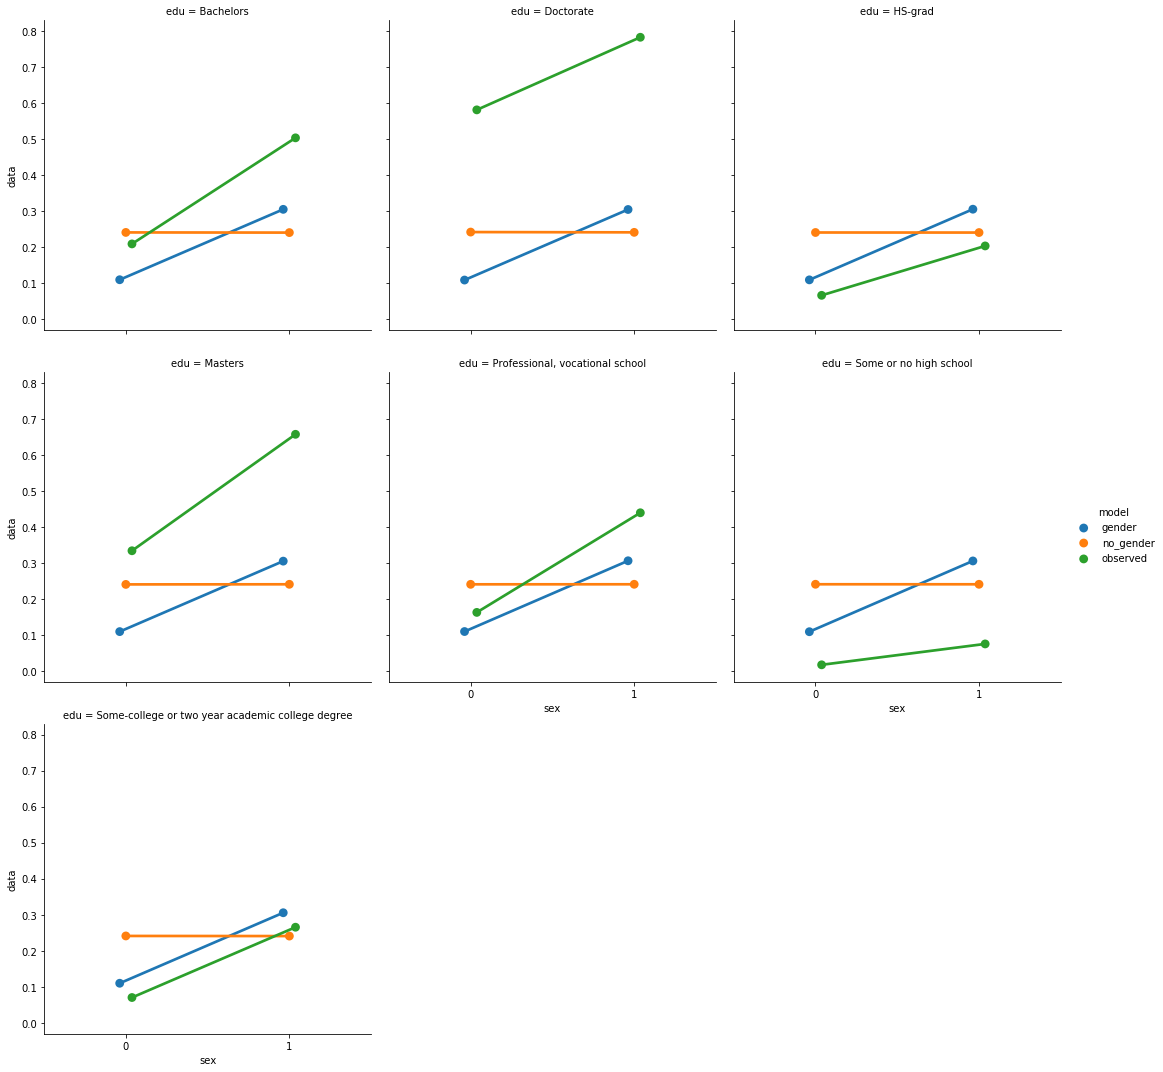

In [13]:
 g = sns.catplot(x="sex", y="data",
                 hue="model", col="edu",
                 data=results, kind="point",
                 dodge=True, col_wrap=3);

We make the posterior predictive plot differnt by facetting by education and model. 

First of all, notice how bad the model predicts the different incomes in different education categories. Clearly, it can't do that by now.

We see that across education, unlike in Simpson's paradox, women earn less on average (indicated by the rising red line) across the different educational levels. So once we account for education in a model, we still expect that the corresponding regressio coefficient reflects that.

So we expect that the `sex` coefficient remains roughly the same:

GridSpec(1, 2, width_ratios=[3, 1])

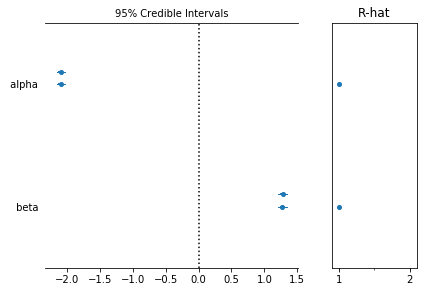

In [14]:
pm.forestplot(trace2)

> 1.4. Following Example 10.1.3, build two models for the classification of an individual's yearly income taking into account education. One of the models should take into account education only the other should take into account gender and education on income.

In [15]:
from sklearn.preprocessing import LabelEncoder

lb_make = LabelEncoder()
df['edu_cat'] = lb_make.fit_transform(df["edu"])
df.head()

,age,sector,edu,marital,race,sex,earning,target,sex_cat,edu_cat
0,39,State-gov,Bachelors,Never-married,White,Male,<=50K,0,1,0
1,50,Self-emp-not-inc,Bachelors,Married-civ-spouse,White,Male,<=50K,0,1,0
2,38,Private,HS-grad,Divorced,White,Male,<=50K,0,1,2
3,53,Private,Some or no high school,Married-civ-spouse,Black,Male,<=50K,0,1,5
4,28,Private,Bachelors,Married-civ-spouse,Black,Female,<=50K,0,0,0


In [16]:
len(df.edu_cat.unique())

7

In [17]:
 with pm.Model() as no_gender_edu:
    
    # Varying intercepts
    alpha = pm.Normal('alpha', mu=0, sd=10, shape=len(df.edu_cat.unique()))
    
    # Logits
    logits = alpha[df.edu_cat.values]
    
    # Likelihood
    obs = pm.Bernoulli('observed', logit_p=logits, observed=df.target)
    trace3 = pm.sample(2000)
    
no_gender_edu.name = 'Education, No Gender'

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [alpha]
Sampling 2 chains: 100%|██████████| 5000/5000 [01:02<00:00, 80.41draws/s]


In [18]:
with pm.Model() as gender_edu:
    
    # Varying intercepts
    alpha = pm.Normal('alpha', mu=0, sd=10, shape=len(df.edu_cat.unique()))
    
    # Gender effect
    beta = pm.Normal('beta', mu=0, sd=10)
    
    # Logits
    logits = alpha[df.edu_cat.values] + beta * df.sex_cat
    
    # Likelihood
    obs = pm.Bernoulli('observed', logit_p=logits, observed=df.target)
    trace4 = pm.sample(2000)
    
gender_edu.name = 'Education & Gender'

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta, alpha]
Sampling 2 chains: 100%|██████████| 5000/5000 [01:05<00:00, 76.01draws/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x123c459e8>,
      dtype=object)

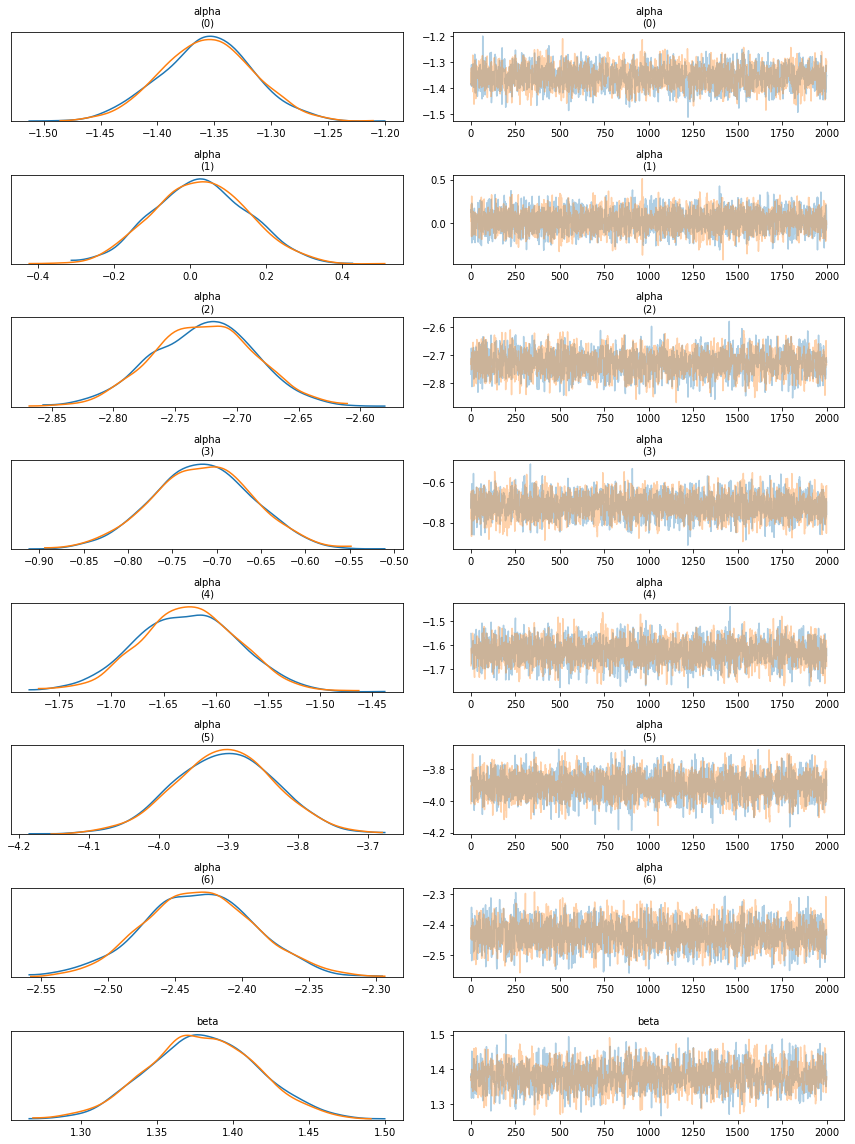

In [19]:
az.plot_trace(trace4)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11f18b748>,
      dtype=object)

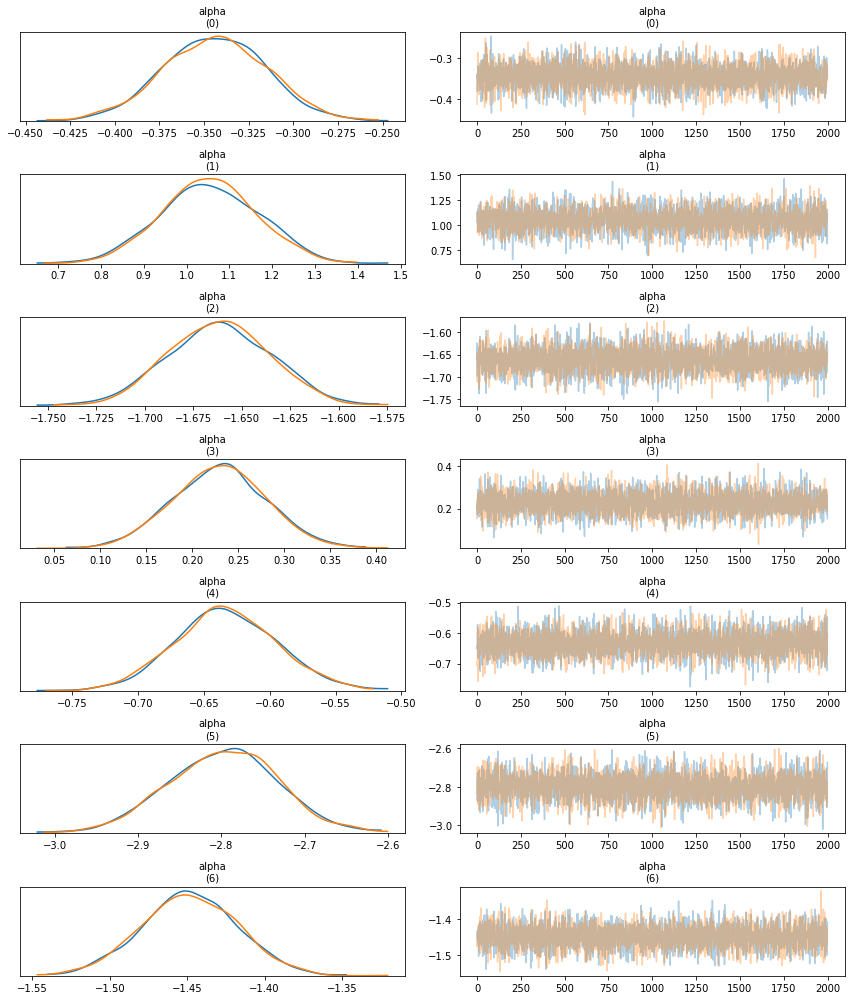

In [20]:

az.plot_trace(trace3)

In [22]:
pm.summary(trace3)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
alpha__0,-0.344501,0.028440,0.000380,-0.400517,-0.288807,5310.141263,0.999842
alpha__1,1.051764,0.111734,0.001999,0.838986,1.267933,3627.954891,0.999778
alpha__2,-1.661918,0.026480,0.000328,-1.712844,-1.611486,6073.056399,0.999755
alpha__3,0.229041,0.050242,0.000661,0.134324,0.331458,5503.006327,0.999750
alpha__4,-0.633490,0.038301,0.000595,-0.706843,-0.557474,5178.932834,0.999873
alpha__5,-2.798994,0.065444,0.000989,-2.928664,-2.672272,4063.784118,0.999824
alpha__6,-1.448824,0.030575,0.000370,-1.507934,-1.388394,6315.174235,0.999787


> 1.5. Replicate the analysis in 10.1.3 using your models; specifically, compute wAIC scores and make a plot like Figure 10.6 (posterior check) to see how well your model fits the data.

We start with the wAIC. We see that all the model weight goes to the model with gender included.

In [ ]:
df_comp_WAIC = pm.compare({no_gender_edu: trace3, gender_edu: trace4})
df_comp_WAIC

We make a posterior predictive check again using a facetted plot:

100%|██████████| 2000/2000 [00:14<00:00, 138.15it/s]
/anaconda/lib/python3.6/site-packages/pandas/core/frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)
/anaconda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


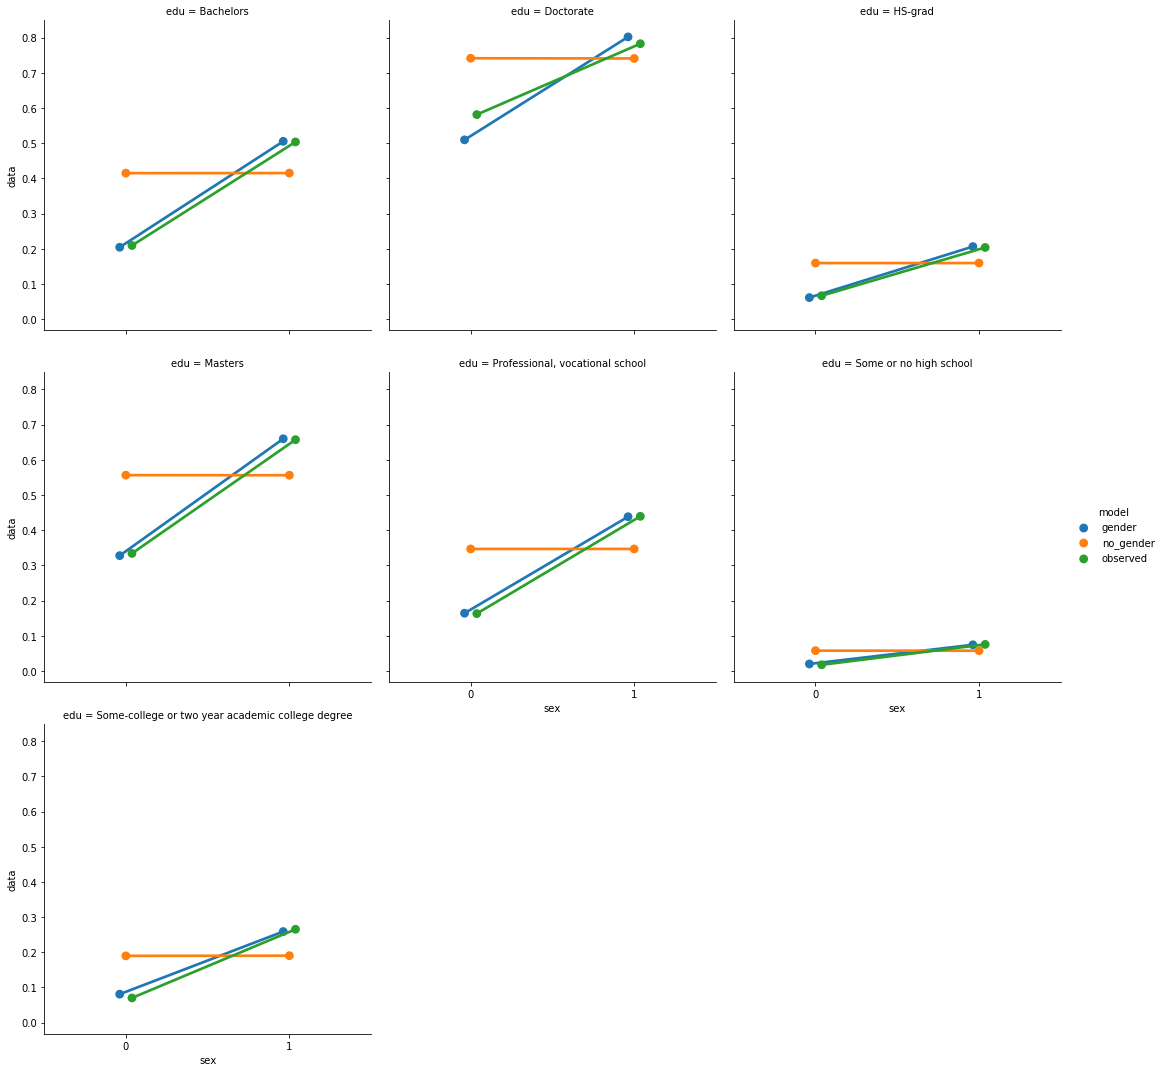

In [25]:
with no_gender_edu:
    sim_no_gender = pm.sample_ppc(trace3)
    
with gender_edu:
    sim_gender = pm.sample_ppc(trace4)

results_edu = pd.DataFrame()

for cat, df_edu in df.groupby(['edu', 'sex_cat']):
    ind = df_edu.index.values
    gender = sim_gender['observed'][:, ind]
    
    gender_df = pd.DataFrame({'edu': cat[0], 'sex': cat[1], 'model': 'gender', 'data': gender.mean(axis=1)},
                             index=np.arange(2000))
    
    
    results_edu = results_edu.append(gender_df)
    
    no_gender_mean = sim_no_gender['observed'][:, ind].mean(axis=1)
    
    no_gender_df = pd.DataFrame({'edu': cat[0], 'sex': cat[1], 'model': 'no_gender', 'data': no_gender_mean},
                             index=np.arange(2000))
    
    
    results_edu = results_edu.append(no_gender_df)
    
    obs = pd.DataFrame([{'edu': cat[0], 'sex': cat[1], 'model': 'observed', 'data': df_edu.target.mean()}])
    results_edu = results_edu.append(obs)


g = sns.catplot(x="sex", y="data",
                hue="model", col="edu",
                data=results_edu, kind="point",
                dodge=True, col_wrap=3);

> 1.6. Using your analysis from 1.3, discuss the effect gender has on income.

When not considering any other variables, as in 1.3, we see that **women have a lower probability of earning more than 50k** (the statement is not more or less than that).

Let's look at the effect size: note that in this case the predicted effect size is constant across education on the probability scale.

In [30]:
results.loc[lambda x: x.model == "gender"].groupby('sex')['data'].mean()

sex
0    0.195248
1    0.420890
Name: data, dtype: float64

So, men have **double** the probability of earning more than 50k.

> 1.7. Using your analysis from 1.5, discuss the effect of gender on income taking into account an individual's education.

We find that women tend to earn less even when adjusted for education. This means that there is no effect  like in Simpson's paradox (at least when considering education only): It's not as simple as saying that women tend to have lower education on average and thus earn less overall.

Also, the model fits the data quite well (which does not mean that it's a perfect model yet. We could make similar plots but across different variables, like in which industry the person is employed, and find that the model fits the data badly again).

Let's look at the effect size again:

In [32]:
results_edu.loc[lambda x: x.model == "gender"].groupby(['sex', 'edu'])['data'].mean().unstack()

edu,Bachelors,Doctorate,HS-grad,Masters,"Professional, vocational school",Some or no high school,Some-college or two year academic college degree
sex,,,,,,,
0,0.204415,0.509587,0.061363,0.327642,0.164016,0.019804,0.080882
1,0.505424,0.802222,0.206340,0.659726,0.438143,0.074192,0.258844


We see that the effect size on the probability scale now depends on the education.

**Gratuitous Titular Reference**:  

If you haven't watched [Crazy Rich Asians](http://www.crazyrichasiansmovie.com/) then it might be time.

If you haven't listened to [Pink Floyd's](https://en.wikipedia.org/wiki/Pink_Floyd) [The Wall](https://en.wikipedia.org/wiki/The_Wall) then it might be time.

Also who are you? :-)

Anyway [You don't need no thought control](https://www.youtube.com/watch?v=YR5ApYxkU-U), [You probably want us teaching staff to leave you kids alone](https://www.youtube.com/watch?v=YR5ApYxkU-U), and [Education is overrated, right?  You don't need it!](https://www.youtube.com/watch?v=YR5ApYxkU-U)

<div class="answer-separator">
------------------------
</div>

## Question 2:  My Sister-In-Law's Baby Cousin Tracy ...

**coding required**

Wikipedia describes the National Annenberg Election Survey as follows -- "National Annenberg Election Survey (NAES) is the largest academic public opinion survey conducted during the American presidential elections. It is conducted by the Annenberg Public Policy Center at the University of Pennsylvania."  In the file [survey.csv](https://piazza.com/redirect/s3?bucket=uploads&prefix=attach%2Fjlo4e4ari3r4wd%2Fj9vjyzv62x149%2Fjop9sr9dh4g5%2Fsurvey.csv) we provide the following data from the 2004 National Annenberg Election Survey:  `age` -- the age of the respondents, `numr` -- the number of responses, and `knowlgbtq` -- the number of people at the given age who have at least one LGBTQ acquaintance.  We want you to model how age influences likelihood of interaction with members of the LGBTQ community in three ways. 


2.1. Using pymc3, create a bayesian linear regression model  with `age` as the quantitative predictor and `knowlgbtq` as the response variable. Plot the mean predictions for ages 0-100, with a 2-sigma envelope.

2.2. Using pymc3, create a 1-D Gaussian Process regression model with the same feature and dependent variables.  Use a squared exponential covariance function. Plot the mean predictions for ages 0-100, with a 2-sigma envelope.

(**Hint: For an example of GP Regression from class see [this GP Recap](http://am207.info/wiki/gpsalmon.html)**)

2.3. How do the models compare? Does age influence likelihood of acquaintance with someone LGBTQ? For Bayesian Linear Regression and GP Regression, how does age affect the variance of the estimates?


> 2.1. Using pymc3, create a bayesian linear regression model  with `age` as the quantitative predictor and `knowlgbtq` as the response variable. Plot the mean predictions for ages 0-100, with a 2-sigma envelope.

We read in the data and add a 'rate' variable to the dataframe, which measures how many percent of the given age know a member of the LGBTQ community. We don't use this variable as target, but we use it to explore that data.

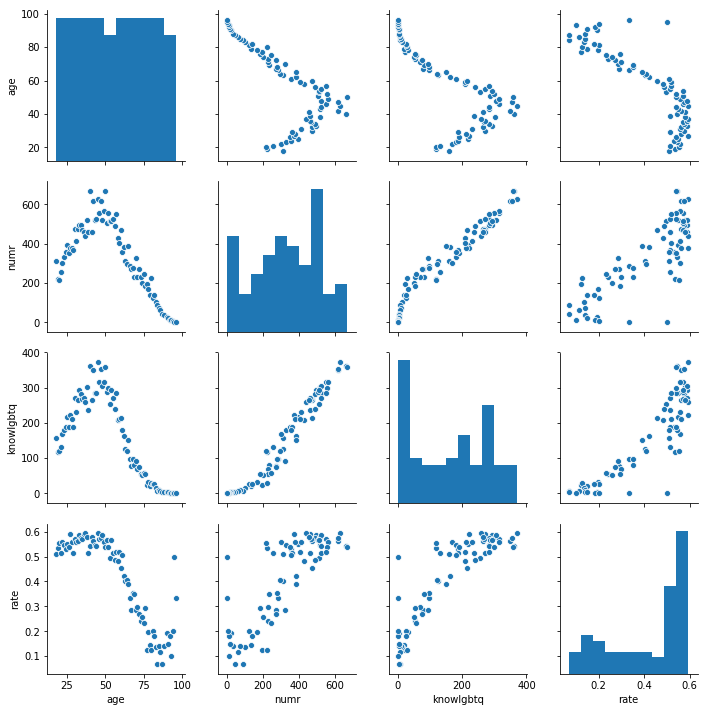

In [2]:
df = pd.read_csv("survey.csv")
df['rate'] = df['knowlgbtq'] / df['numr']
sns.pairplot(df)

It seems senisble to assume that the likelihood is a **binomial** with rate $\theta_i$ and number of respondents $\text{numr}_i$ for age $i$. Furthermore, $\theta_i = \alpha + \beta \times \text{age}_i$.

We center and scale the age variable and specify a $\mathcal N(0, 2)$ prior.

In [3]:
df['age_centered'] = (df['age'] - df['age'].mean()) / df['age'].std()
df.head()

,age,numr,knowlgbtq,rate,age_centered
0,18,310,158,0.509677,-1.692212
1,19,221,118,0.533937,-1.648360
2,20,217,120,0.552995,-1.604509
3,21,255,131,0.513725,-1.560658
4,22,301,168,0.558140,-1.516806


In [4]:
ages_centered_shared = shared(np.asarray(df['age_centered'].values))

with pm.Model() as linear_model:
    intercept = pm.Normal('intercept', 0, 10)
    age_coef = pm.Normal('age_coef', 0, 2)
    
    logits = intercept + age_coef * ages_centered_shared
    rate = pm.invlogit(logits)
    
    obs = pm.Binomial('obs', n=df['numr'], p=rate, observed=df['knowlgbtq'])

In [5]:
with linear_model:
    linear_trace = pm.sample(draws=10000, n_init=5000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [age_coef, intercept]
Sampling 2 chains: 100%|██████████| 21000/21000 [00:20<00:00, 1005.53draws/s]
The acceptance probability does not match the target. It is 0.8793124811554365, but should be close to 0.8. Try to increase the number of tuning steps.


Some diagnostics: we start with the traceplot. The two chains lie nicely on top of each other and the samples values don't get stuck for longer times.

/anaconda/lib/python3.6/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/anaconda/lib/python3.6/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x12aebbeb8>,
      dtype=object)

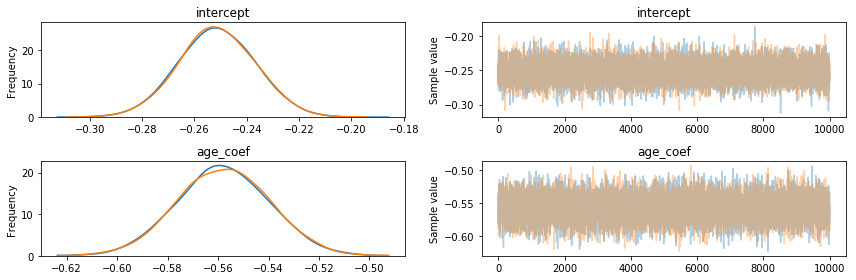

In [6]:
pm.traceplot(linear_trace)

The `Rhat` statistics and `n_eff` values look reasonable as well.

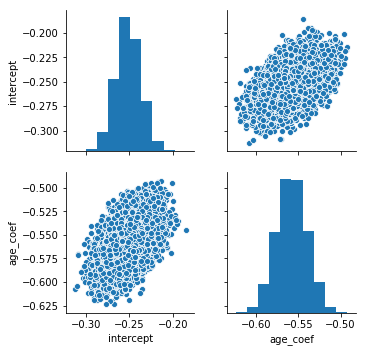

In [7]:
sns.pairplot(pm.trace_to_dataframe(linear_trace, varnames=['intercept', 'age_coef']))

We plot a 95% prediction confidence interval instead as there's not reason to use a normal approximation (1.96 standard deviations).

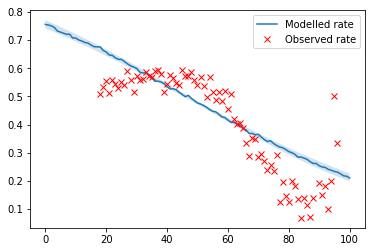

In [18]:
ages = np.array(list(range(101)))
ages.shape=(101, 1)

ages_centered = (ages - df.age.mean()) / df.age.std()

age_coef = linear_trace['age_coef']
age_coef.shape = (1, 20000)

counterfactual = scipy.special.expit(linear_trace['intercept'] + np.dot(ages_centered, age_coef))


#mean_pred = counterfactual.mean(axis=1)
mean_pred = scipy.stats.bernoulli.rvs(counterfactual).mean(axis=1)
err = np.quantile(counterfactual, axis=1, q=[0.025, 0.975])

ages.shape = (101)

plt.plot(ages, mean_pred, label='Modelled rate')
plt.fill_between(ages, err[0, :], err[1, :], alpha=.2)
plt.plot(df['age'], df['rate'], 'rx', label='Observed rate')
plt.legend()

2.2. Using pymc3, create a 1-D Gaussian Process regression model with the same feature and dependent variables.  Use a squared exponential covariance function. Plot the mean predictions for ages 0-100, with a 2-sigma envelope.

Let's model the **rate** as a 1-D Gaussian Process.

In [9]:
with pm.Model() as model:

    # Lengthscale
    ρ = pm.HalfCauchy('ρ', 1)
    η = pm.HalfCauchy('η', 1)
    
    M = pm.gp.mean.Linear(coeffs=(df.rate.values/df.age.values).mean())
    K = (η**2) * pm.gp.cov.ExpQuad(1, ρ) 
    
    σ = pm.HalfCauchy('σ', 1)
    
    gp = pm.gp.Marginal(mean_func=M, cov_func=K)
    gp.marginal_likelihood('recruits', X=df.age.values.reshape(-1,1), 
                           y=df.rate.values, noise=σ)

/anaconda/lib/python3.6/site-packages/theano/tensor/basic.py:6592: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x


In [10]:
with model:
    gp_trace = pm.sample(10000, cores=-1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/anaconda/lib/python3.6/site-packages/theano/tensor/basic.py:6592: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
/anaconda/lib/python3.6/site-packages/theano/tensor/basic.py:6592: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
/anaconda/lib/python3.6/site-packages/theano/tensor/basic.py:6592: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `

Diagnostics look ok:

/anaconda/lib/python3.6/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/anaconda/lib/python3.6/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/anaconda/lib/python3.6/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x12af16160>,
      dtype=object)

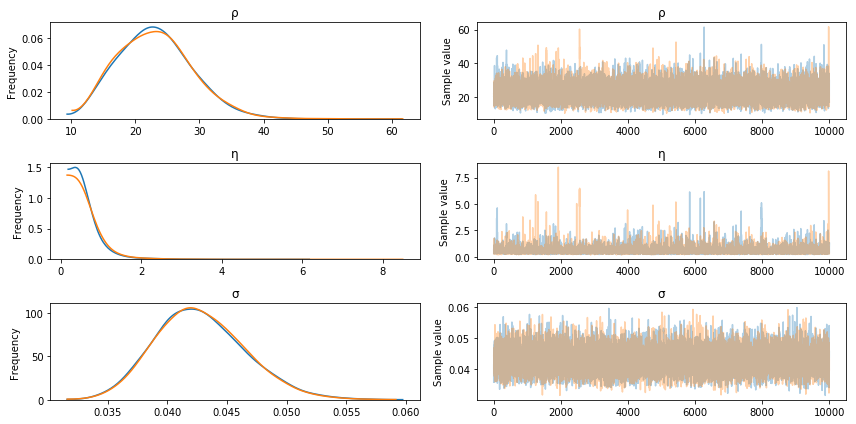

In [11]:
pm.traceplot(gp_trace)

In [13]:
pm.summary(gp_trace)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
ρ,23.097423,5.743492,0.066692,12.594787,33.915423,7467.029407,0.999951
η,0.614245,0.414068,0.005611,0.195403,1.284870,5071.654472,1.000032
σ,0.042824,0.003751,0.000029,0.035703,0.050112,13047.636786,0.999969


Let's predict on ages between 0 and 100:

In [12]:
X_pred = np.linspace(0, 100, 100).reshape(-1, 1)
with model:
    gp_pred = gp.conditional("rate_pred4", X_pred)
    gp_samples = pm.sample_ppc(gp_trace, vars=[gp_pred], samples=1000)

/anaconda/lib/python3.6/site-packages/theano/tensor/basic.py:6592: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
  0%|          | 0/1000 [00:00<?, ?it/s]/anaconda/lib/python3.6/site-packages/theano/tensor/basic.py:6592: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
/anaconda/lib/python3.6/site-packages/theano/tensor/basic.py:6592: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will b

In [207]:
pred_mean = gp_samples['rate_pred4'].mean(axis=0)
pred_ci = np.quantile(gp_samples['rate_pred4'], q=[0.025, 0.975], axis=0)

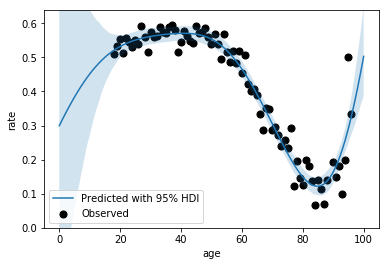

In [228]:
ax = df.plot.scatter(x='age', y='rate', c='k', s=50, label='Observed')
ax.set_ylim(0, None)
plt.plot(X_pred, pred_mean, label='Predicted with 95% HDI')
ax.fill_between(X_pred.reshape(-1), pred_ci[0, :], pred_ci[1, :], alpha=0.2)
plt.legend()

> 2.3. How do the models compare? Does age influence likelihood of acquaintance with someone LGBTQ? For Bayesian Linear Regression and GP Regression, how does age affect the variance of the estimates?


There clearly is an effect. Moreless, the older you are, the less likely it is that you someone from the LGBTQ community. This effect comes out in both models, but the non-linearity in this effects is much better captured in the Gaussian proces model.

In terms of the variance of the predictions, we see that it is relatively constant and small for the Bayeisan "linear" regression. For the Gaussian process model, the vraiance is massive where we have no data, otherwise it is quite small.

**Gratuitous Titular References**:  

Massachusett's own [Joiner Lucas](https://en.wikipedia.org/wiki/Joyner_Lucas) blew up in November 2017 with the release of his single ["I'm Not Racist"](https://www.youtube.com/watch?v=43gm3CJePn0) on Youtube.  The video quickly went viral. The title comes from the song's lyrics (and references that degrees of separation that can be involved in individual experience with members of any under-represented group).

Given the oncoming cold spell [Winter Blues](https://www.youtube.com/watch?v=I7_ofdl9Wfs) another popular track may be relevant.

<div class="answer-separator">
------------------------
</div>

## Question 3 - AM207 HWs Out (A OK I MIC DROP)!

**coding required**

In the dataset "reviews_processed.csv", you'll find a database of Yelp reviews for a number of restaurants. These reviews have already been processed and transformed by someone who has completed the (pre) modeling process described in Problem #1. That is, imagine the dataset in "reviews_processed.csv" is the result of feeding the raw Yelp reviews through the pipeline someone built for Problem #1.

The following is a full list of columns in the dataset and their meanings:

I. Relevant to 3.1-3.5:

  1. "review_id" - the unique identifier for each Yelp review
  2. "topic" - the subject addressed by the review (0 stands for food and 1 stands for service)
  3. "rid" - the unique identifier for each restaurant
  4. "count" - the number of sentences in a particular review on a particular topic
  5. "mean" - the probability of a sentence in a particular review on a particular topic being positive, averaged over total number of sentences in the review related to that topic.
  6. "var" - the variance of the probability of a sentence in a particular review on a particular topic being positive, taken over all sentences in the review related to that topic.

II. Relevant (possibly) to more complex models:

  1. "uavg" - the average star rating given by a particular reviewer (taken across all their reviews)
  2. "stars" - the number of stars given in a particular review
  3. "max" - the max probability of a sentence in a particular review on a particular topic being positive
  4. "min" - the min probability of a sentence in a particular review on a particular topic being positive

The following schema illustrates the model of the raw data that is used to generate "reviews_processed.csv":
<img src="restuarant_model.pdf">

***Warning:*** *this is a "real" data science problem in the sense that the dataset in "reviews_processed.csv" is large. We understand that a number of you have limited computing resources, so you are encouraged but not required to use the entire dataset. If you wish you may use 10 restaurants from the dataset, as long as your choice of 10 contains a couple of restaurants with a large number of reviews and a couple with a small number of reviews.*


When the value in "count" is low, the "mean" value can be very skewed.

3.1. Following the [SAT prep school example discussed in lab](https://am207.info/wiki/gelmanschoolstheory.html) (and influenced your answers for HW 10 Question #1), set up a Bayesian model (that is, write functions encapsulating the pymc3 code) for a reviewer $j$'s opinion of restaurant $k$'s food and service (considering the food and service separately).  You should have a model for each restaurant and each aspect being reviewed (food and serivce). For restaurant $k$, you will have a model for $\{\theta_{jk}^{\text{food}}\}$ and one for $\{\theta_{jk}^{\text{service}}\}$, where $\theta_{jk}$ is the positivity of the opinion of the $j$-th reviewer regarding the $k$-th restaurant. 

**Hint:** What quantity in our data naturally corresponds to $\bar{y}_j$'s in the prep school example? How would you calculate the parameter $\sigma_j^2$ in the distribution of $\bar{y}_j$ (note that, contrary to the school example, $\sigma_j^2$ is not provided explictly in the restaurant data)?

3.2. Just to test your that modeling makes sense choose 1 restaurant and run your model from 3.1 on the food and service aspects for that restaurant.  Create 10K samples  each for the food and service model for your chosen restuarant and visualize your samples via a traceplot for each aspect of the restaurant reviews.

3.3. Use your model from 3.1 to produce estimates for $\theta_{jk}$'s for multiple restaurants. Pick a few (try for 5 but if computer power is a problem, choose 2) restaurants and for each aspect ("food" and "service") of each restaurant, plot your estimates for the $\theta$'s against the values in the "mean" column (corresponding to this restaurant). 

For the chosen restaurants, for each aspect ("food" and "service"), generate shrinkage plots and probability shrinkage plots as follows:

**Shrinkage plot for a restaurant, topic**:

> The aim for this plot is to see the shrinkage from sample means (error bars generated from standard error) to $\theta_{jk}$'s (error bars generated from theta variance).  
>
> The sample means of reviews are plotted at $y=0$ and the posterior means ($\theta_{ik}$) are plotted at $y=1$. For each review connect the sample mean to the posterior mean with a line.  Show error bars on the sample mean points using standard error and on the ($\theta_{jk}$) points using variance.

**Probability Shrinkage plot for a restaurant, topic**:

> The aim for this plot is to see the shrinkage from the classification probabilities from the sample means of reviews to the classification probabilities of $\theta_{jk}$'s.  The classification probabilities are calculated from the gaussian at the given mean and variance. The sample means and standard error are fed into the gaussian to generate one set of classification probabilities.  The $\theta_{jk}$ estimates and variances are fed into the gaussian to generate the other set of variances.
>
> The y values are the classification probability (calculated as 1-cdf) using the normal distribution at a given mean and variance.
>
> The sample means of reviews are plotted with $y$'s obtained by using the sample means as the means in the normal above, with line segments (error bars) representing the standard error. 
>
> The posterior means ($\theta_{jk}$) are plotted with $y$'s obtained using the posterior means (thetas) in the gaussian above, and variances on the thetas with line segments (error bars) representing the variances on the $\theta_{jk}$'s.
>
>We've provided you some code to generate a shrinkage plot and a probability shrinkage plot is included in this notebook, but feel free to implement your own. The code should also help elucidate the text above.

Example of a shrinkage plot:
<img src="https://piazza.com/redirect/s3?bucket=uploads&prefix=attach%2Fjlo4e4ari3r4wd%2Fj9vjyzv62x149%2Fjop9gx9xfww9%2Fshrinkage.png" width="400" height="400"/>

Example of a probability shrinkage plot:
<img src="https://piazza.com/redirect/s3?bucket=uploads&prefix=attach%2Fjlo4e4ari3r4wd%2Fj9vjyzv62x149%2Fjop9fsbbu9bs%2Fshrinkage_prob.png" width="400" height="400"/>


3.4. Based on your shrinkage plots and probability shrinkage plots in 3.3 discuss the statistical benefits of modeling each reviewer's opinion using your hierarchical model rather than approximating the reviewer opinion with the value in "mean".

3.5. Aggregate, in a simple but reasonable way, the reviewer's opinions given a pair of overall scores for each restaurant -- one for food and one for service. Rank the restaurants by food score and then by service score. 

(**Hint:**  Think what an average score for each aspect would do here?)

3.6. Discuss the statistical weakness of ranking by these scores.

(**Hint:** What is statistically problematic about the way you aggregated the reviews of each restaurant to produce an overall food or service score? This is also the same problem with summarizing a reviewer's opinion on a restaurants service and food based on what they write.)  


> 3.1. Following the [SAT prep school example discussed in lab](https://am207.info/wiki/gelmanschoolstheory.html) (and influenced your answers for HW 10 Question #1), set up a Bayesian model (that is, write functions encapsulating the pymc3 code) for a reviewer $j$'s opinion of restaurant $k$'s food and service (considering the food and service separately).  You should have a model for each restaurant and each aspect being reviewed (food and serivce). For restaurant $k$, you will have a model for $\{\theta_{jk}^{\text{food}}\}$ and one for $\{\theta_{jk}^{\text{service}}\}$, where $\theta_{jk}$ is the positivity of the opinion of the $j$-th reviewer regarding the $k$-th restaurant. 

> **Hint:** What quantity in our data naturally corresponds to $\bar{y}_j$'s in the prep school example? How would you calculate the parameter $\sigma_j^2$ in the distribution of $\bar{y}_j$ (note that, contrary to the school example, $\sigma_j^2$ is not provided explictly in the restaurant data)?

In [34]:
data = pd.read_csv("reviews_processed.csv")
data.head()

,review_id,topic,rid,count,max,mean,min,stars,uavg,var
0,---sV8KdwfBoDw38KW_WnQ,0,VgLiSW1iGkpzIEXOgvUBEw,5,0.689383,0.558430,0.312919,3,3.285714,0.024112
1,---sV8KdwfBoDw38KW_WnQ,1,VgLiSW1iGkpzIEXOgvUBEw,5,0.816901,0.554300,0.211441,3,3.285714,0.050309
2,--0MzHNy7MVBRvZCOAeRPg,0,4gLecengX1JeGILm7DwU3w,3,0.746711,0.574416,0.360240,5,3.829268,0.038655
3,--0MzHNy7MVBRvZCOAeRPg,1,4gLecengX1JeGILm7DwU3w,6,0.848065,0.657755,0.476156,5,3.829268,0.014583
4,--2NT40xmHh9oBLumzdjhA,0,4ZZab5hinFzHtj3sE8vQWg,5,0.764218,0.601008,0.337710,2,4.181818,0.026742


An individual school from the lab corresponds to a `review_id`, with `mean` being the $\bar y_j$. A combination (`topic`, `rid`) corresponds to the whole experiment.

In [140]:
def calc_model(data, topic, rid):
    """
    Calculate MCMC for topic and restaurant
    """
    #print(topic)
    data_small = data.loc[lambda x: x.rid==rid].loc[lambda x: x.topic==topic]
    n = data_small.shape[0]
    #print(data_small)
    y_obs = data_small['mean'].values
    tau_obs = data_small['count'].values / data_small['var'].values
    # var_pooled = np.sum(data_small['var'] * data_small['count']) / np.sum(data_small['count'])
    # sigma = np.sqrt(var_pooled / data_small['count'])
    #print(data_small)
    with pm.Model() as model:
        # Hyperprior
        mu = pm.Normal('mu', mu=0, sd=0.5)
        tau = pm.HalfCauchy('tau', beta=0.5)
        
        nu = pm.Normal('nu', 0, 1, shape=n)
        # Prior
        theta = pm.Deterministic('theta', mu + nu * tau)
        sigma = pm.HalfCauchy('sigma', beta=0.5) / np.sqrt(data_small['count'])
        
        # Likelihood
        y = pm.Normal('y_obs', theta, sd=sigma, observed=y_obs)
        samples = pm.sample(draws=2000, target_accept=0.98, tune=1000)
    
    return model, samples

> 3.2. Just to test your that modeling makes sense choose 1 restaurant and run your model from 3.1 on the food and service aspects for that restaurant.  Create 10K samples  each for the food and service model for your chosen restuarant and visualize your samples via a traceplot for each aspect of the restaurant reviews.

In [142]:
model, trace = calc_model(data, 0, data.rid[0])

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, nu, tau, mu]
Sampling 2 chains: 100%|██████████| 6000/6000 [00:17<00:00, 335.96draws/s]
There were 75 divergences after tuning. Increase `target_accept` or reparameterize.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


In [143]:
pm.summary(trace)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
mu,0.699411,0.048478,0.001423,0.612464,0.809420,1089.243090,1.000334
nu__0,-0.801798,0.865928,0.020695,-2.517066,0.965975,1724.596260,0.999783
nu__1,0.080402,0.782503,0.015650,-1.559724,1.610450,3013.944838,1.000214
nu__2,-0.278636,0.844648,0.018930,-1.963406,1.373571,1882.974853,1.000503
nu__3,-0.234047,0.758328,0.016225,-1.753484,1.366823,2332.602637,0.999772
nu__4,0.557636,1.000636,0.031045,-1.460217,2.405757,654.262982,1.003895
nu__5,0.592007,0.826487,0.017545,-1.206657,2.188810,2073.434410,0.999796
nu__6,0.264965,0.809575,0.016042,-1.408576,1.857245,2831.880046,1.000113
nu__7,0.194133,0.819797,0.015540,-1.506960,1.753317,2523.354819,0.999919
tau,0.081590,0.053226,0.001757,0.000228,0.175417,769.435660,1.004731


/anaconda/lib/python3.6/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/anaconda/lib/python3.6/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/anaconda/lib/python3.6/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/anaconda/lib/python3.6/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1230d5400>,
      dtype=object)

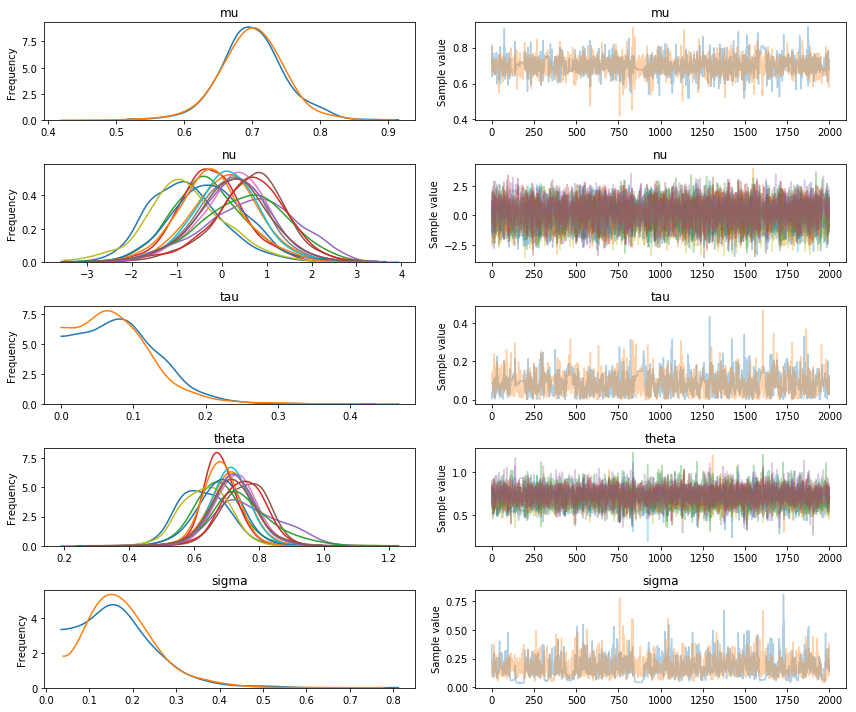

In [144]:
pm.traceplot(trace)

In [145]:
model, trace = calc_model(data, 1, data.rid[0])

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, nu, tau, mu]
Sampling 2 chains: 100%|██████████| 6000/6000 [00:19<00:00, 300.32draws/s]
There were 87 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7088478590355002, but should be close to 0.8. Try to increase the number of tuning steps.
There were 54 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.


In [146]:
pm.summary(trace)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
mu,0.642770,0.174209,0.009038,0.289178,1.047981,127.904054,1.003249
nu__0,-0.418946,0.861731,0.026557,-2.184989,1.217884,1063.371504,0.999765
nu__1,0.444431,0.806720,0.022275,-1.125622,2.089939,1237.748489,1.002330
nu__2,0.059206,0.799933,0.023308,-1.471155,1.662504,962.380823,0.999999
nu__3,0.227938,0.819523,0.019596,-1.509708,1.845491,1687.887337,0.999797
tau,0.198976,0.189463,0.009766,0.000090,0.599153,158.540254,1.004298
theta__0,0.582197,0.127938,0.002705,0.316568,0.841768,2288.121090,1.000119
theta__1,0.723265,0.177563,0.005056,0.372157,1.049426,1261.537192,1.000487
theta__2,0.652330,0.164473,0.003812,0.272392,0.945118,2132.585952,0.999770
theta__3,0.686599,0.195477,0.006093,0.286000,1.073745,846.620219,1.000275


/anaconda/lib/python3.6/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/anaconda/lib/python3.6/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/anaconda/lib/python3.6/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/anaconda/lib/python3.6/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x12cb7fba8>,
      dtype=object)

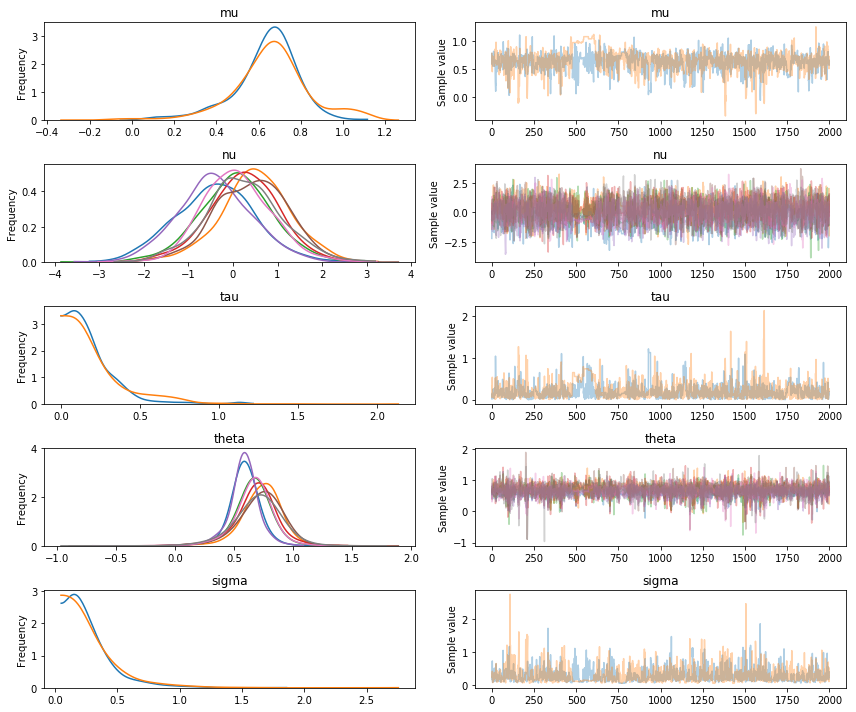

In [147]:
pm.traceplot(trace)

> 3.3. Use your model from 3.1 to produce estimates for $\theta_{jk}$'s for multiple restaurants. Pick a few (try for 5 but if computer power is a problem, choose 2) restaurants and for each aspect ("food" and "service") of each restaurant, plot your estimates for the $\theta$'s against the values in the "mean" column (corresponding to this restaurant). 

In [404]:
import itertools
from scipy.special import erf

# Use 1-cdf at 0.5 to model the probability of having positive sentiment
# it basically tells you the area under the gaussian after 0.5 (we'll assume 
# positive sentiment based on the usual probability > 0.5 criterion)

prob = lambda mu, vari: .5 * (1 - erf((0.5- mu) / np.sqrt(2 * vari)))

# fix a restaurant and an aspect (food or service)
# "means" is the array of values in the "mean" column for the restaurant and the aspect 
#         in the dataset
# "thetas" is the array of values representing your estimate of the opinions of reviewers 
#          regarding this aspect of this particular restaurant
# "theta_vars" is the array of values of the varaiances of the thetas
# "counts" is the array of values in the "count" column for the restaurant and the aspect 
#.         in the dataset
# FEEL FREE TO RE-IMPLEMENT THESE

def shrinkage_plot(means, thetas, mean_vars, theta_vars, counts, ax):
    """
    a plot that shows how review means (plotted at y=0) shrink to
    review $theta$s, plotted at y=1
    """
    data = zip(means, thetas, mean_vars / counts, theta_vars, counts)   
    palette = itertools.cycle(sns.color_palette())
    with sns.axes_style('white'):
        for m,t, me, te, c in data: # mean, theta, mean errir, thetax error, count
            color=next(palette)
            # add some jitter to y values to separate them
            noise=0.04*np.random.randn()
            noise2=0.04*np.random.randn()
            if me==0:
                me = 4
            # plot shrinkage line from mean, 0 to
            # theta, 1. Also plot error bars
            ax.plot([m, t], [noise+0.0,1+noise2],'o-', color=color, lw=1)
            ax.errorbar([m,t],[noise+0.0,1+noise2], xerr=[np.sqrt(me), np.sqrt(te)], color=color,  lw=1)
        ax.set_yticks([])
        ax.set_xlim([0,1])
        ax.set_title("Shrinkage Plot")
        sns.despine(offset=-2, trim=True, left=True)
    return plt.gca()

def prob_shrinkage_plot(means, thetas, mean_vars, theta_vars, counts, ax):
    """
    a plot that shows how review means (plotted at y=prob(mean)) shrink to
    review $theta$s, plotted at y=prob(theta)
    """
    data = zip(means, thetas, mean_vars / counts, theta_vars, counts)
    palette = itertools.cycle(sns.color_palette())
    with sns.axes_style('white'):
        for m,t, me, te, c in data: # mean, theta, mean errir, theta error, count
            color = next(palette)
            # add some jitter to y values to separate them
            noise = 0.001 * np.random.randn()
            noise2 = 0.001 * np.random.randn()
            if me == 0: #make mean error super large if estimated as 0 due to count=1
                me = 0.5
            p = prob(m, me)
            peb = prob(t, te)
            # plot shrinkage line from mean, prob-based_on-mean to
            # theta, prob-based_on-theta. Also plot error bars
            ax.plot([m, t],[p, peb],'o-', color=color, lw=1)
            ax.errorbar([m, t],[p + noise, peb + noise2], xerr=[np.sqrt(me), np.sqrt(te)], color=color, lw=1)
        #ax = plt.gca()
        ax.set_title("Probability shrinkage plot")
        ax.set_xlim([0, 1])
        ax.set_ylim([0, 1.05])
    return ax

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, nu, tau, mu]
Sampling 2 chains: 100%|██████████| 6000/6000 [00:14<00:00, 413.91draws/s]
There were 70 divergences after tuning. Increase `target_accept` or reparameterize.
There were 58 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


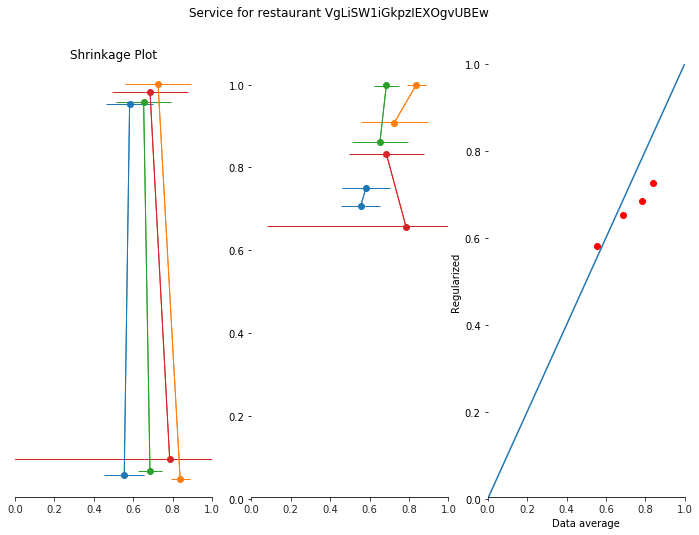

In [408]:
rid, topic = data.rid[0], "Service"
def plot_restaurant(rid, topic):
    if topic == "Food":
        topic_id = 0
    elif topic == "Service":
        topic_id = 1
        
    model, trace = calc_model(data, topic_id, rid)
        
    data_small = data.loc[data.rid == rid].loc[lambda x: x.topic == topic_id]
    f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=False)
    f.set_figheight(8)
    f.set_figwidth(12)
    f.suptitle("{} for restaurant {}".format(topic, rid))

    shrinkage_plot(data_small['mean'], trace['theta'].mean(axis=0),
                   data_small['var'],  trace['theta'].var(axis=0), 
                   data_small['count'], ax1)

    prob_shrinkage_plot(data_small['mean'], trace['theta'].mean(axis=0),
                   data_small['var'],  trace['theta'].var(axis=0), 
                   data_small['count'], ax2)

    ax3.plot(data_small['mean'], trace['theta'].mean(axis=0), 'ro')
    ax3.set_xlim([0, 1])
    ax3.set_ylim([0, 1])
    ax3.set_xlabel("Data average")
    ax3.set_ylabel("Regularized")
    ax3.plot([0, 1], [0, 1])
    
plot_restaurant(rid, topic)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, nu, tau, mu]
Sampling 2 chains: 100%|██████████| 6000/6000 [00:13<00:00, 439.05draws/s]
There were 152 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6438064931296219, but should be close to 0.8. Try to increase the number of tuning steps.
There were 46 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, nu, tau, mu]
Sampling 2 chains: 100%|██████████| 6000/6000 [00:19<00:00, 307.19draws/s]
There were 72 divergences after tuning. Increase `target_accept` or reparameterize.
There were 23 divergences after tuning. Increase `target_accept` or reparameteri

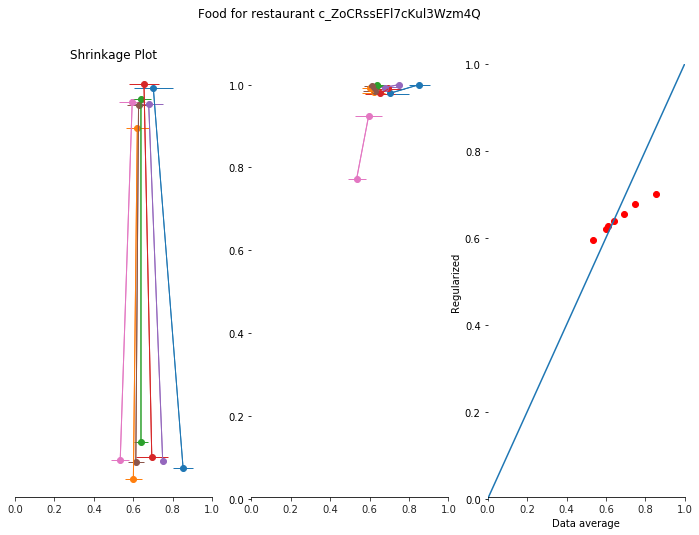

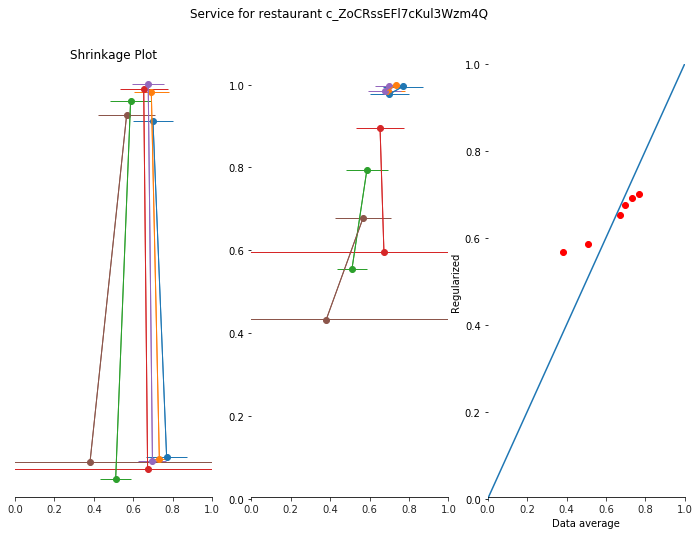

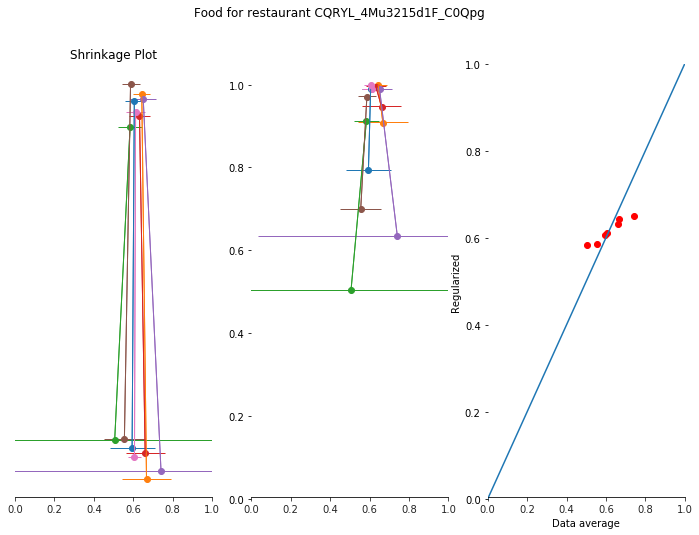

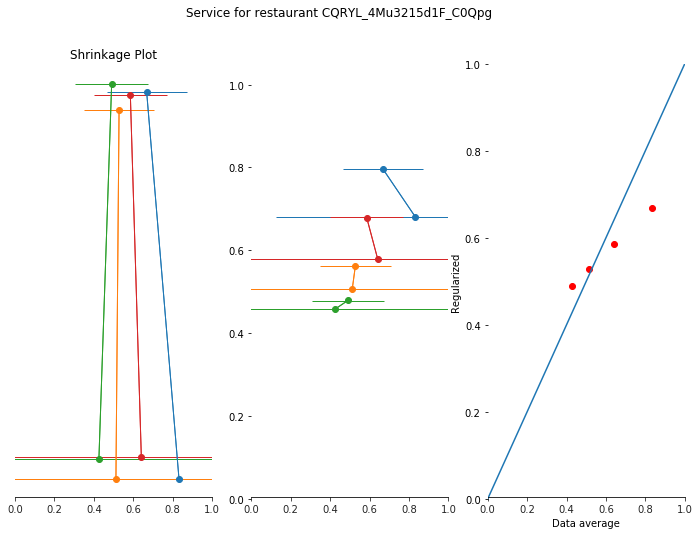

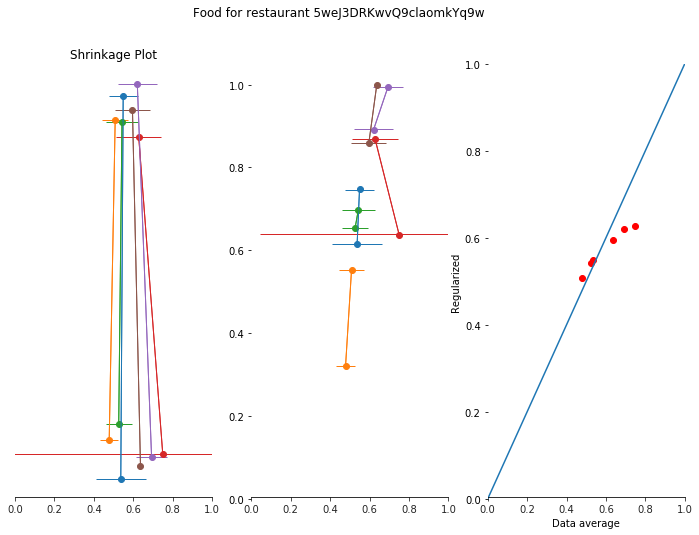

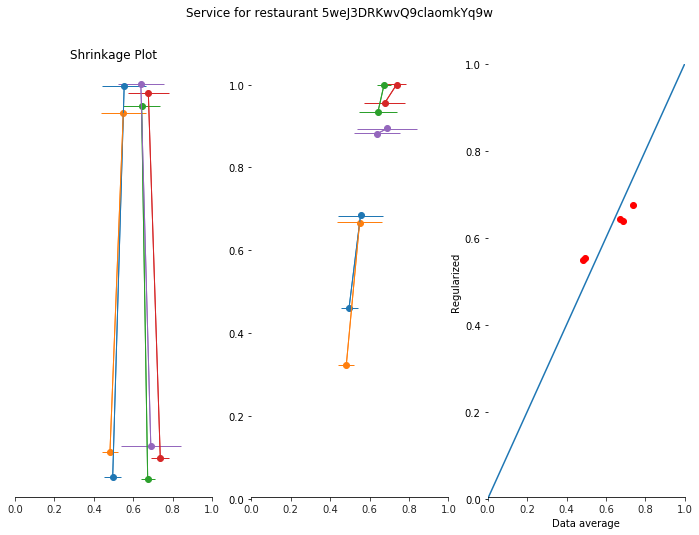

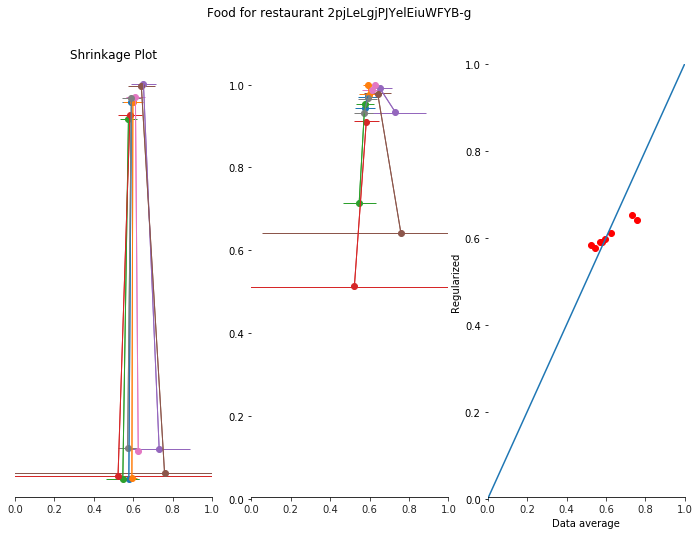

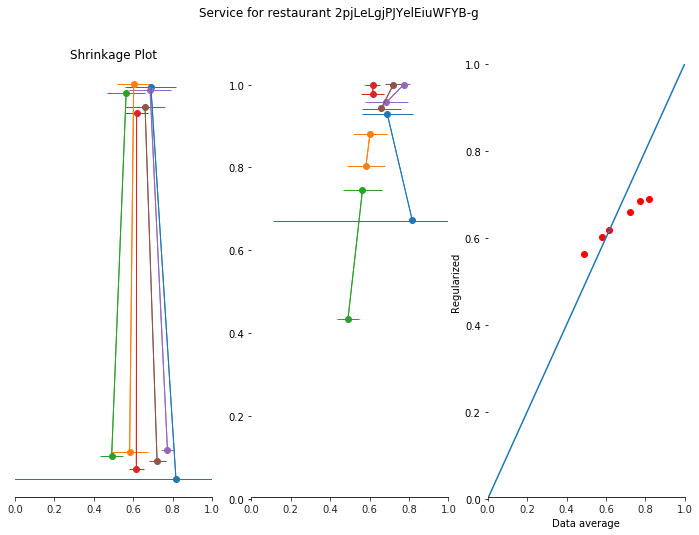

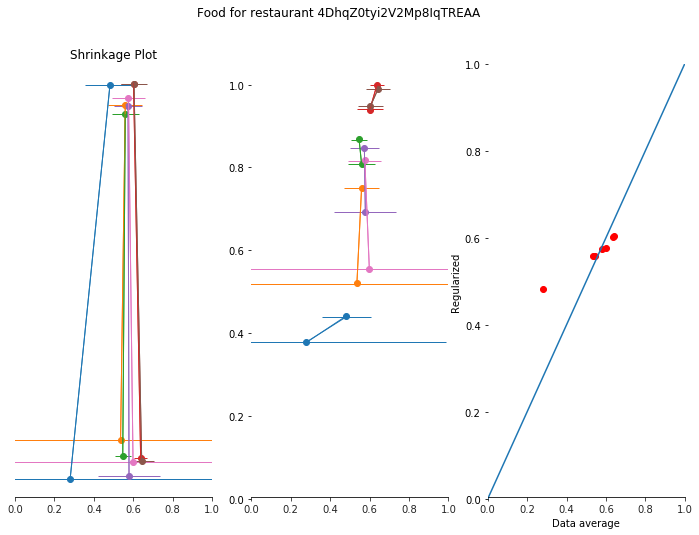

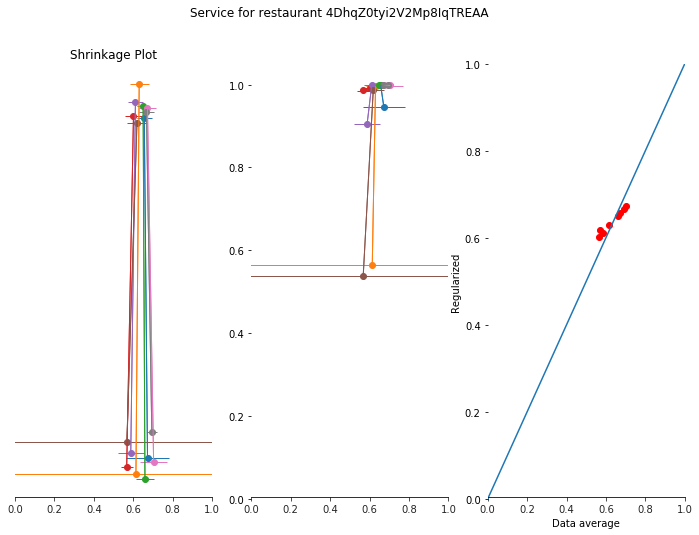

In [418]:
sampled = np.random.choice(data['rid'].unique(), size=5)

for rid in sampled:
    for topic in ["Food", "Service"]:
        plot_restaurant(rid, topic)

> 3.4. Based on your shrinkage plots and probability shrinkage plots in 3.3 discuss the statistical benefits of modeling each reviewer's opinion using your hierarchical model rather than approximating the reviewer opinion with the value in "mean".

We see that the main benefit is that reviews with small number of sentences are regularized towards the overall average. This means that the posterior predictive for such a review is less extrem than using the sample (MLE) data. In particular, the "best" restaurants are not necessarily the ones with a small number of (by chance) very good reviews.

If we want to interpret the $\theta$ parameters as the "goodness" of the review, then the smaller reviews are weighted less heavily than longer reviews.

> 3.5. Aggregate, in a simple but reasonable way, the reviewer's opinions **giving** a pair of overall scores for each restaurant -- one for food and one for service. Rank the restaurants by food score and then by service score. 

(**Hint:**  Think what an average score for each aspect would do here?)

The simplest way to aggregate the food and service aspects is to take **weighted average**, where the weights are given by the counts. Such a weighted average can be interpreted as the probability of a sentence being positive.

In [375]:
g = data.groupby(['topic', 'rid'], as_index=False)
ranked = g.apply(lambda x: (x['count'] * x['mean']).sum() / x['count'].sum()).reset_index().rename(columns={0: 'mean'})
counts = g.apply(lambda x: x['count'].sum()).reset_index().rename(columns={0: 'n_sentences'})
ranked_with_counts = pd.merge(ranked, counts)

In [381]:
ranked_with_counts.sort_values('mean', ascending=False).head(10)

,topic,rid,mean,n_reviews
22767,1,zVtUCRpaMgGerHFV9jkOIA,0.906165,7
12318,1,3xdV-7di_YD3MVqs3Pa7-g,0.874340,2
13061,1,80peW-kivTjBBAITGTcqDQ,0.867193,4
19595,1,i4b0jbsOsET7biMw5KhPDg,0.864867,2
17717,1,YJJ1eOz1gdh_bSy8DKmaNQ,0.864722,4
13573,1,AxdOGtJ8bJmL8uXB0AQS5A,0.853011,3
13611,1,BESmH-lmMm34_EefL8X9fQ,0.847358,4
14421,1,FcBIKYJ2HHLMScsnw5JRAg,0.843501,7
18769,1,dGar8pDtGR5_6IIRqMfcIQ,0.842705,11
17706,1,YCSCDbvvpnlIpVJ9_ECHcg,0.840991,2


> 3.6. Discuss the statistical weakness of ranking by these scores.

(**Hint:** What is statistically problematic about the way you aggregated the reviews of each restaurant to produce an overall food or service score? This is also the same problem with summarizing a reviewer's opinion on a restaurants service and food based on what they write.)  

We see that **regularization** would've been needed: the ones that come up on top are the ones that have very few sentences. Compare with the plot below that shows the histogram of sentence counts.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11fef98d0>]],
      dtype=object)

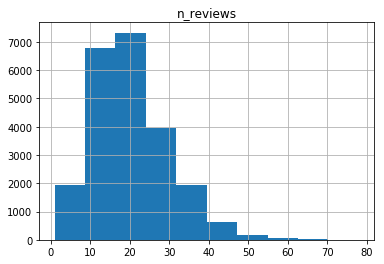

In [382]:
ranked_with_counts.hist('n_sentences')

**Gratuitous Titular Reference**:  

Thank you for putting up with us -- No more HWs!  No more gratuitous titular references!

We'll leave with a [Steve Aoki](http://www.steveaoki.com/) and [K-Pop](https://en.wikipedia.org/wiki/K-pop) style [Mic Drop](https://www.youtube.com/watch?v=kTlv5_Bs8aw).  Take it away [BTS](https://en.wikipedia.org/wiki/BTS_(band)).  Don't [Burn the Stage](https://www.youtube.com/watch?v=uwgDg8YnU8U) on the way out!

[AM207 HW Crew out!](https://www.youtube.com/watch?v=Tg0hLMop200)

<div class="answer-separator">
------------------------
</div>